# Surface Soil Moisture (SSM)

In this notebook, we follow the concept presented in https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/ to estimate the soil moisture content using the concept of change detection over three year of time interval as a openEO workflow.

References:
* https://eo4society.esa.int/projects/s1-for-surface-soil-moisture/
* https://www.sciencedirect.com/science/article/pii/S2352340921006296?via%3Dihub

Therefore the surface soil moisture is calculated using the following formula: 

$$SSM=\frac{\operatorname{sigma}_0-dry_{\text {ref }}}{wet_{\text {ref }}-dry_{\text {ref }}}$$

where, $sigma_{0}$ = Current backscatter intensity

$dry_{ref}$ = historic minimum backscatter in past 3 years

$wet_{ref}$ = historic maximum backscatter in past 3 years

In [1]:
import openeo
import json
import openeo.processes 

connection = openeo.connect("openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


Let us define the area of interest.

In [2]:
# defining area of interest
spatial_extent = {"west": 139.194, "south": -35.516, "east": 139.535, "north":  -35.284}

Let us first start by creating a reference cube with time-interval of 3 years, followed by a datacube representing the current situation for a temporal interval of approximately a month.

In [3]:
#Reference Cube
s1_ref = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2017-02-02","2020-02-02"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_ref = s1_ref.sar_backscatter(coefficient="sigma0-ellipsoid")

In [5]:
#Current DateCube
s1_cur = connection.load_collection(
    "SENTINEL1_GRD",
    temporal_extent=["2020-02-02", "2020-02-28"],
    spatial_extent=spatial_extent,
    bands=["VV"],
)
s1_cur = s1_cur.sar_backscatter(coefficient="sigma0-ellipsoid")

As we don't want to download all of the data within the specified time interval, we need to reduce that data. Thus, we use `reduce_dimension` with first, min and max reducers, respectively, for current, dry reference and wet reference datacube.

In [6]:
s1_cur = s1_cur.reduce_dimension(dimension='t',reducer='first')
dry_ref = s1_ref.reduce_dimension(dimension='t',reducer='min')
wet_ref = s1_ref.reduce_dimension(dimension='t',reducer='max')

In [7]:
#calculate Surface Soil Moisture
SSM = (s1_cur-dry_ref)/(wet_ref-dry_ref)

Furthermore, to filter wet and urban areas from our soil moisture dataset, we reduce the temporal dimension of our datacube by using a mean reducer to get an average reference datacube. This is followed by normalising the backscatter values by Log with base 10.

In [8]:
average_ref = s1_ref.reduce_dimension(dimension='t',reducer='mean')
average_ref = average_ref.apply(process=lambda data: 10 * openeo.processes.log(data, base=10))

Suppose if average of urban area is $>-6db$ and water area if average is $<-17db$, let's create a mask for these areas. These values were set as describes in https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/ 

In [9]:
VV = average_ref.band("VV")
mask = ((VV > -6) | (VV < -17))

#now let us apply the mask
SSM = SSM.mask(mask)

This generates a final SSM datacube after applying urban and permanent water body mask.

In [10]:
# Let's download the data
SSM.execute_batch(title="Surface Soil Moisture Malinong", outputfile="SoilMoisture_aus.nc")

0:00:00 Job 'j-240220633e374d1ebadd8a70156937a6': send 'start'
0:00:18 Job 'j-240220633e374d1ebadd8a70156937a6': created (progress N/A)
0:00:23 Job 'j-240220633e374d1ebadd8a70156937a6': created (progress N/A)
0:00:29 Job 'j-240220633e374d1ebadd8a70156937a6': created (progress N/A)
0:00:37 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:00:47 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:01:00 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:01:15 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:01:35 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:01:59 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:02:38 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:03:16 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:04:03 Job 'j-240220633e374d1ebadd8a70156937a6': running (progress N/A)
0:05:28 Job 'j-240220633e374d1ebadd8a70156937a6': running (pr

<BatchJob job_id='j-240220633e374d1ebadd8a70156937a6'>

## Let us plot the result

In [11]:
import matplotlib.pyplot as plt
import xarray as xr

In [12]:
ds = xr.load_dataset("SoilMoisture_aus.nc")

In [13]:
data = ds[["VV"]].to_array(dim="bands")

Text(0.5, 1.0, 'Surface Soil Moisture')

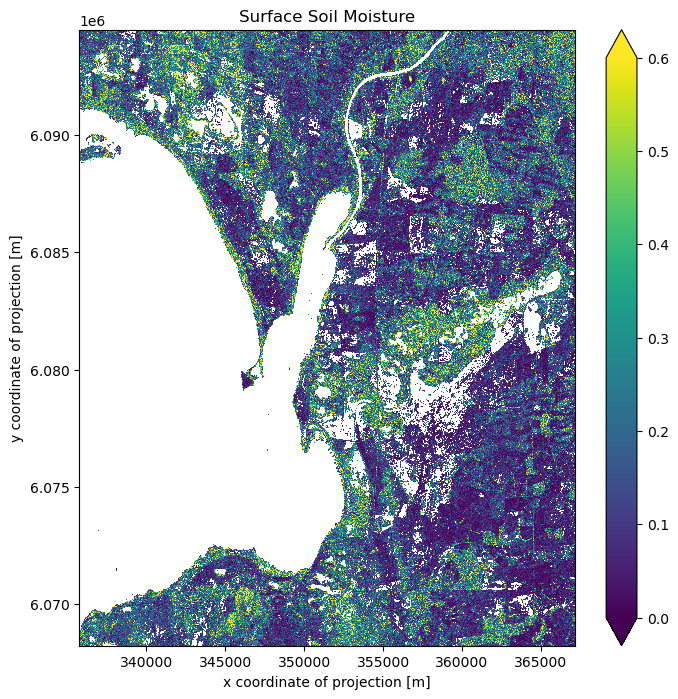

In [42]:
fig, axes = plt.subplots(ncols=1, figsize=(8, 8), dpi=100, sharey=True)
data[0].plot.imshow(ax=axes, vmax=0.6, vmin=0)
axes.set_title("Surface Soil Moisture")

As suggested [here](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-1/soil_moisture_estimation/), to avoid the effect of outliers, the soil moisture ranges from 0 to 0.6 is plotted. Here the white colour represents the masked-out area, including permanent water bodies and urban areas.